# Optimization Problem

## Objective Function

The optimization problem defining the workload scheduling problem can be written as:

$$
\text{min} \quad \sum_{t} \left( r x_t + q u_t \right)
$$
# Optimization Problem

The optimization problem can be written as:

$$
\text{min} \quad \sum_{t} \left( r x_t + q u_t \right)
$$

Subject to the following constraints:

$$
u_t + k s_t = G_t \quad \forall t \quad \text{(Demand constraint)}
$$

$$
c_{t+1} = c_t + s_t \quad \forall t \quad \text{(Storage evolution)}
$$

$$
c_T = c_0 \quad \text{(Final charge constraint)}
$$

$$
x_{t+1} = x_t + L_t - u_t \quad \forall t \quad \text{(Workload evolution)}
$$


$$
x_T = 0 \quad \text{(Backlog clearance)}
$$

$$
x_t, c_t, u_t \geq 0 \quad \forall t \quad \text{(Non-negativity)}
$$


Where:
- \( x_t \): backlog or deferred workload at time \( t \)
- \( u_t \): amount of workload processed at time \( t \)
- \( r \): cost per unit of backlog — penalizes unprocessed/delayed work
- \( q \): cost per unit of processing — energy, labor, or other operational costs
- \( L_t \): new workload arriving at time \( t \)


## Constraints

### Demand Constraint:
$$
u_t + k s_t = G_t \quad \forall t
$$

Where:
- \( G_t \): power consumption (e.g., grid energy) at time \( t \)
- \( s_t \): power stored into battery at time \( t \)
- \( k \): conversion factor between storage and power (e.g., efficiency)

### Storage Evolution:
$$
c_{t+1} = c_t + s_t \quad \forall t
$$

### Final Charge Constraint:
$$
c_T = c_0
$$

### Workload Evolution:
$$
x_{t+1} = x_t + L_t - u_t \quad \forall t
$$

Where:
- \( L_t \): new workload arriving at time \( t \)

### Backlog Clearance:
$$
x_T = 0
$$

### Non-Negativity:
$$
x_t \geq 0, \quad c_t \geq 0, \quad u_t \geq 0 \quad \forall t
$$

## Summary
This linear program determines:
- Workload processing decisions (\( u_t \))
- Energy usage and storage (\( s_t \), \( c_t \))
- Backlog management (\( x_t \))

All while minimizing the total cost from both deferred (\( r x_t \)) and completed work (\( q u_t \)), under operational and physical constraints.


In [108]:
import pandas as pd
workload_path = "data/Workload/GoogleClusteData_CPU_Data_Hourly_1.csv"
renewable_path = "data/CarbonIntensity/CAISO_NG_&_avgCI.csv"
workload = pd.read_csv(workload_path)
renewable_gen = pd.read_csv(renewable_path)
workload.head()
Load = workload["cpu_load"]*100
caiso_wind_cap = 6284
DC_wind_cap = 120
caiso_wind_gen = renewable_gen["WND"]
DC_wind_gen = (caiso_wind_gen/caiso_wind_cap)*DC_wind_cap
T = 5
# G = DC_wind_gen.round()
G = DC_wind_gen.fillna(0).astype(int).to_list()
G[:T]


[59, 57, 50, 48, 49]

In [109]:
G = [10, 8, 6, 7, 5]
L = [6, 7, 8, 5, 4]


In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Input data (already loaded from previous context)
# Generation (G_t) over 10 time steps (e.g., hours of the day)
# G = [30, 40, 50, 60, 75, 90, 100, 80, 60, 40]  # Peak generation occurs midday and early evening

# # Load (L_t) over the same 10 time steps
# L = [35, 45, 50, 55, 70, 85, 90, 80, 65, 40]  # Load peaks during evening hours
L = [
    30, 25, 20, 20, 25, 35, 50, 60, 65, 60, 55, 50, 
    55, 65, 75, 85, 90, 95, 90, 70, 60, 50, 40, 35
]  # sum = 1400
G = [
     0, 0, 0, 0, 7, 21, 50, 86, 114, 129, 143, 150,
   143, 122, 86, 57, 29, 14, 7, 0, 0, 0, 0, 0
]  # sum ≈ 1526


T = len(G)

# Plotting helper function for each scenario
def plot_results(title, served, soc=None, second_plot=None):
    total_demand = sum(L)
    total_served = sum(served)

    fig, axs = plt.subplots(2 if soc else 1, 2 if second_plot else 1, figsize=(14, 6 if soc else 4), squeeze=False)
    
    # Demand comparison
    ax = axs[0, 0]
    ax.fill_between(range(T), L, color='skyblue', alpha=0.4, label='Original Load (L[t])')
    ax.fill_between(range(T), served, color='orange', alpha=0.4, label='Served Load')
    ax.plot(range(T), L, marker='o', color='blue', linewidth=2)
    ax.plot(range(T), served, marker='s', color='darkorange', linewidth=2)
    ax.set_title(f"{title} — Load vs Served")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Energy")
    ax.text(T - 1.5, max(max(L), max(served)) * 0.9,
            f"Total Demand = {total_demand:.1f}\nTotal Served = {total_served:.1f}",
            bbox=dict(facecolor='white', alpha=0.7), fontsize=11)
    ax.legend()
    ax.grid(True)

    # Secondary plot
    if second_plot:
        ax_gen = axs[0, 1]
        ax_gen.bar(range(T), G, color='seagreen', alpha=0.7)
        ax_gen.set_title("Generation (G[t])")
        ax_gen.set_xlabel("Time Step")
        ax_gen.set_ylabel("Energy")
        ax_gen.grid(True)

    # Battery state of charge
    if soc:
        ax_soc = axs[1, 0] if second_plot else axs[0, 1]
        ax_soc.plot(range(T+1), soc, marker='s', color='purple', label="Battery SoC")
        ax_soc.fill_between(range(T+1), 0, soc, color='purple', alpha=0.2)
        ax_soc.set_title("Battery State of Charge")
        ax_soc.set_xlabel("Time Step")
        ax_soc.set_ylabel("Stored Energy")
        ax_soc.legend()
        ax_soc.grid(True)

    plt.tight_layout()
    plt.show()



In [111]:
# Parameters
q = 1.0  # Cost per unit energy used
r = 1  # Cost per unit backlog
k = 1  # Storage energy conversion factor

# Scenario 1, Naive: Served Load(t) = generation(t) (No scheduling, no storage)

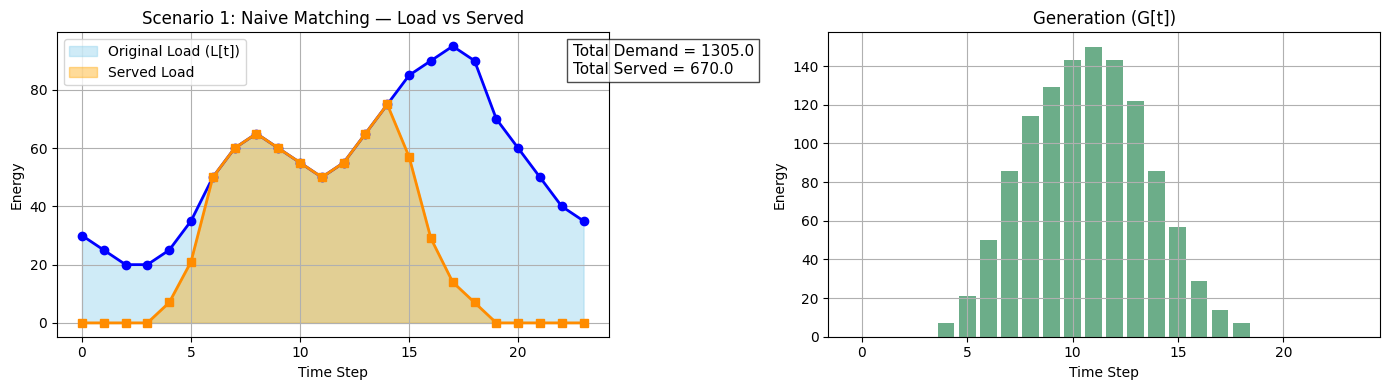

In [112]:
served_1 = [min(L[t], G[t]) for t in range(T)]
plot_results("Scenario 1: Naive Matching", served_1, second_plot=True)


# Scenario 2 — Workload Scheduling without Storage


Geneartion [0, 0, 0, 0, 7, 21, 50, 86, 114, 129, 143, 150, 143, 122, 86, 57, 29, 14, 7, 0, 0, 0, 0, 0], total generation = 1158
Load [30, 25, 20, 20, 25, 35, 50, 60, 65, 60, 55, 50, 55, 65, 75, 85, 90, 95, 90, 70, 60, 50, 40, 35], total load = 1305
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 20.04.6 LTS")

CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 50 rows, 49 columns and 98 nonzeros
Model fingerprint: 0xcaf2f36f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+02]
Presolve removed 44 rows and 32 columns
Presolve time: 0.01s
Presolved: 6 rows, 17 columns, 22 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0400000e+03   4.787500e+01   0.000000e+00      0s
       1    3.4350000e+03   0.0000

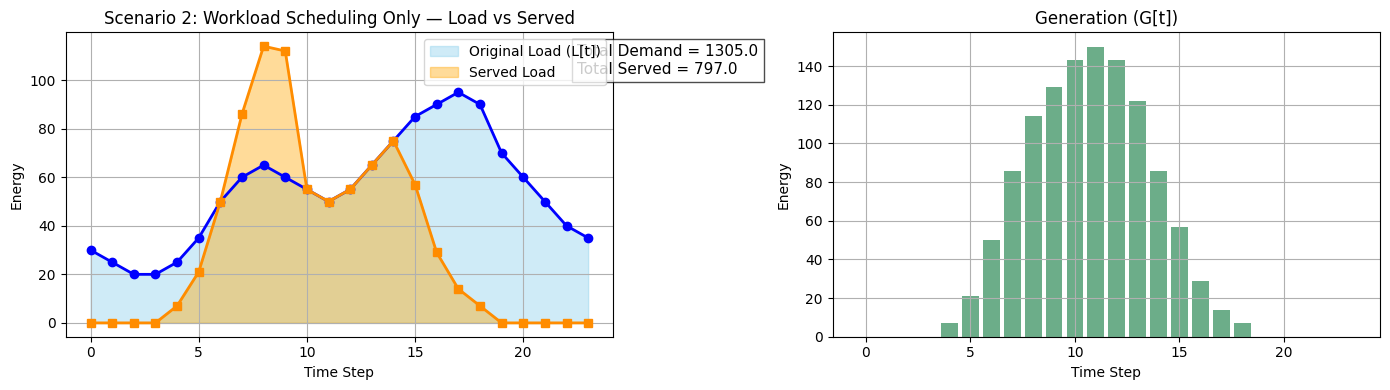

In [113]:
import gurobipy as gp
from gurobipy import GRB

print(f"Geneartion {G}, total generation = {sum(G)}")
print(f"Load {L}, total load = {sum(L)}")

# Model
m2 = gp.Model("workload_scheduling_no_storage")

# Decision variables
u = m2.addVars(T, name="u", lb=0)        # Energy used
x = m2.addVars(T+1, name="x", lb=0)      # Backlog

# Initial condition
m2.addConstr(x[0] == 0, "initial_backlog")

# Dynamics and constraints
for t in range(T):
    m2.addConstr(u[t] <= G[t], name=f"generation_limit_{t}")
    m2.addConstr(x[t+1] == x[t] + L[t] - u[t], name=f"backlog_update_{t}")

# Terminal condition
m2.addConstr(x[T] >= 0, "terminal_backlog")

# Objective: Minimize backlog and energy cost (incentivizes serving more load)
m2.setObjective(gp.quicksum(r * x[t] for t in range(T+1)), GRB.MINIMIZE)

# Optimize
m2.optimize()

# Extract and plot results
if m2.status == GRB.OPTIMAL:
    served_2 = [u[t].X for t in range(T)]
    plot_results("Scenario 2: Workload Scheduling Only", served_2, second_plot=True)


# Scenario 3: Storage, no workload scheduling

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 20.04.6 LTS")

CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 73 rows, 97 columns and 193 nonzeros
Model fingerprint: 0x7986eeae
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+02]
Presolve removed 61 rows and 74 columns
Presolve time: 0.01s
Presolved: 12 rows, 23 columns, 39 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0300000e+03   1.438750e+02   0.000000e+00      0s
       7    1.1580000e+03   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.158000000e+03


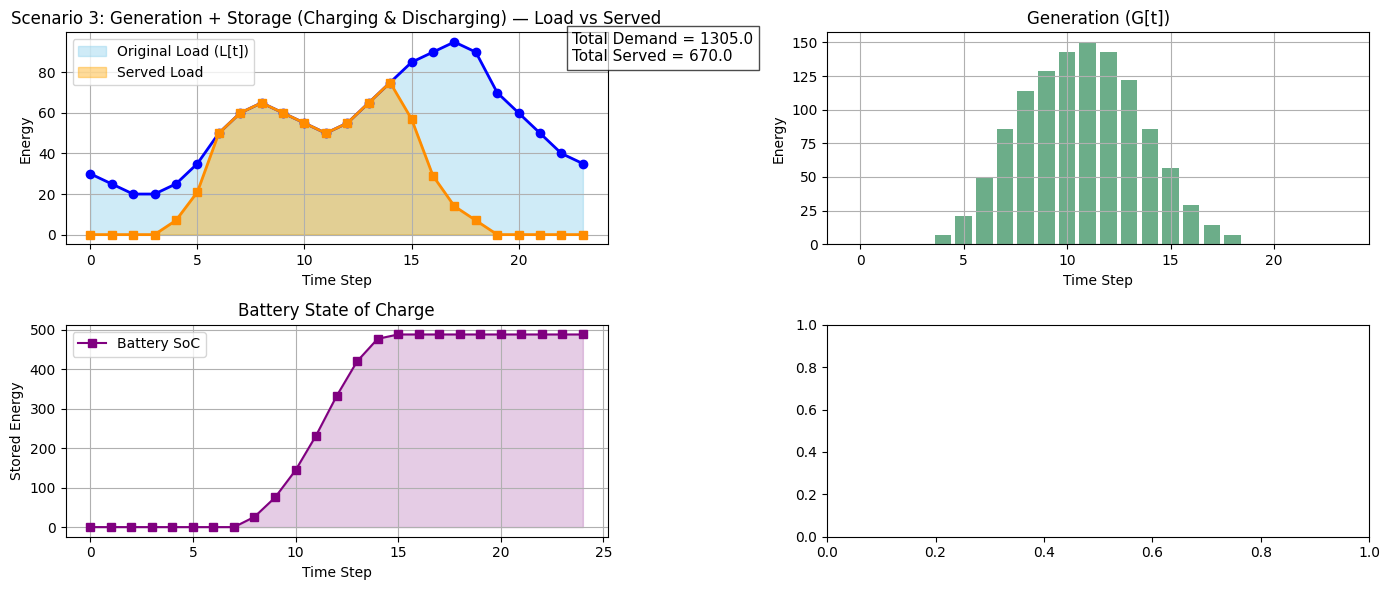

In [121]:
import gurobipy as gp
from gurobipy import GRB

# Given values


# Model
m3 = gp.Model("generation_storage_with_charging_discharging")

# Decision variables
u = m3.addVars(T, name="u", lb=0)              # Energy used to meet load (no negative use)
s_charge = m3.addVars(T, name="s_charge", lb=0)  # Energy charged into the storage
s_discharge = m3.addVars(T, name="s_discharge", lb=0)  # Energy discharged from storage
c = m3.addVars(T+1, name="c", lb=0)             # Battery storage level at each time step

# Initial condition for battery storage
m3.addConstr(c[0] == 0, "initial_storage")

# Constraints
for t in range(T):
    # Energy used to meet load
    m3.addConstr(u[t] <= L[t], name=f"meet_load_{t}")
    
    # Energy balance equation: G[t] = u[t] + s_charge[t] - s_discharge[t]
    m3.addConstr(u[t] + s_charge[t] - s_discharge[t] == G[t], name=f"energy_balance_{t}")
    
    # Update storage level: c[t+1] = c[t] + s_charge[t] - s_discharge[t]
    m3.addConstr(c[t+1] == c[t] + s_charge[t] - s_discharge[t], name=f"storage_update_{t}")

# Final condition: the battery should be empty at the end
# m3.addConstr(c[T] == 0, "terminal_storage")

# Objective: minimize energy used (serving load) and energy storage transitions (charging/discharging)
m3.setObjective(gp.quicksum(q * u[t] + r * (s_charge[t] + s_discharge[t]) for t in range(T)), GRB.MINIMIZE)

# Optimize
m3.optimize()

# Plot results
if m3.status == GRB.OPTIMAL:
    served_3 = [u[t].X for t in range(T)]  # Energy served to meet the load
    soc_3 = [c[t].X for t in range(T+1)]  # State of charge at each time step
    plot_results("Scenario 3: Generation + Storage (Charging & Discharging)", served_3, soc=soc_3, second_plot=True)


# scenario 4: Workload scheduling + storage

In [115]:
import gurobipy as gp
from gurobipy import GRB

# Model
m4 = gp.Model("workload_storage_scheduling_scenario_4")

# Decision variables
u = m4.addVars(T, name="u", lb=0)              # Energy used to meet load
s_charge = m4.addVars(T, name="s_charge", lb=0)  # Energy charged into storage
s_discharge = m4.addVars(T, name="s_discharge", lb=0)  # Energy discharged from storage
x = m4.addVars(T+1, name="x", lb=0)             # Backlog at each time step
c = m4.addVars(T+1, name="c", lb=0)             # Storage level (state of charge) at each time step

# Initial conditions
m4.addConstr(x[0] == 0, "initial_backlog")
m4.addConstr(c[0] == 0, "initial_storage")

# Dynamics and constraints
for t in range(T):
    # Energy used to meet the load (all load must be met)
    # m4.addConstr(u[t] == L[t], name=f"meet_load_{t}")
    
    # Energy balance equation: G[t] = u[t] + s_charge[t] - s_discharge[t]
    m4.addConstr(u[t] + s_charge[t] - s_discharge[t] == G[t], name=f"energy_balance_{t}")
    
    # Update storage level: c[t+1] = c[t] + s_charge[t] - s_discharge[t]
    m4.addConstr(c[t+1] == c[t] + s_charge[t] - s_discharge[t], name=f"storage_update_{t}")
    
    # Backlog update: x[t+1] = x[t] + L[t] - u[t]
    m4.addConstr(x[t+1] == x[t] + L[t] - u[t], name=f"backlog_update_{t}")

# Terminal conditions: no backlog and battery is empty at the end
m4.addConstr(x[T] == 0, "terminal_backlog")
# m4.addConstr(c[T] == 0, "terminal_storage")

# Objective: minimize energy use (serving load) and energy storage transitions (charging/discharging)
m4.setObjective(gp.quicksum(q * u[t] + r * (s_charge[t] + s_discharge[t]) for t in range(T)), GRB.MINIMIZE)

# Optimize the model
m4.optimize()

# Print results
if m4.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Scenario 4:")
    for t in range(T):
        print(f"Time {t}: u={u[t].X:.2f}, s_charge={s_charge[t].X:.2f}, s_discharge={s_discharge[t].X:.2f}, x={x[t].X:.2f}, c={c[t].X:.2f}")
    print(f"Final: x[T]={x[T].X:.2f}, c[T]={c[T].X:.2f}")
    
    # Optionally, you can also plot the results
    served_4 = [u[t].X for t in range(T)]  # Energy served to meet the load
    soc_4 = [c[t].X for t in range(T+1)]  # State of charge at each time step
    plot_results("Scenario 4: Integrated Model (Energy Usage, Storage, and Backlog)", served_4, soc=soc_4, second_plot=True)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 20.04.6 LTS")

CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 75 rows, 122 columns and 243 nonzeros
Model fingerprint: 0xd1e3a5c6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+02]
Presolve removed 26 rows and 42 columns
Presolve time: 0.01s
Presolved: 49 rows, 80 columns, 160 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4991800e+02   4.680051e+02   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.00 work units)
Infeasible model


In [116]:
import gurobipy as gp
from gurobipy import GRB



# Randomly generated (or define your own) G_t and L_t

# Model
m = gp.Model("workload_storage_scheduling")

# Decision variables
u = m.addVars(T, name="u", lb=0)        # energy used
s = m.addVars(T, name="s", lb=0)        # storage charged
x = m.addVars(T+1, name="x", lb=0)      # backlog
c = m.addVars(T+1, name="c", lb=0)      # storage

# Initial conditions
m.addConstr(x[0] == 0, "initial_backlog")
m.addConstr(c[0] == 0, "initial_storage")

# Dynamics and constraints
for t in range(T):
    m.addConstr(u[t] + k * s[t] == G[t], name=f"energy_balance_{t}")
    m.addConstr(c[t+1] == c[t] + s[t], name=f"storage_update_{t}")
    m.addConstr(x[t+1] == x[t] + L[t] - u[t], name=f"backlog_update_{t}")

# Terminal conditions
m.addConstr(x[T] == 0, "terminal_backlog")
# m.addConstr(c[T] == 0, "terminal_storage")

# Objective: minimize energy use + backlog cost
m.setObjective(gp.quicksum(q * u[t] + r * x[t] for t in range(T)), GRB.MINIMIZE)

# Optimize
m.optimize()

# Print results
if m.status == GRB.OPTIMAL:
    print("\nOptimal Schedule:")
    for t in range(T):
        print(f"Time {t}: u={u[t].X:.2f}, s={s[t].X:.2f}, x={x[t].X:.2f}, c={c[t].X:.2f}")
    print(f"Final: x[T]={x[T].X:.2f}, c[T]={c[T].X:.2f}")


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 20.04.6 LTS")

CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 75 rows, 98 columns and 195 nonzeros
Model fingerprint: 0x447b685d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+02]
Presolve removed 14 rows and 27 columns
Presolve time: 0.01s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Infeasible model


In [117]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

if m.status == GRB.OPTIMAL:
    served = [u[t].X for t in range(T)]
    c_vals = [c[t].X for t in range(T+1)]
    total_demand = sum(L)
    total_served = sum(served)

    fig = plt.figure(figsize=(14, 8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])

    # --- Left: Load vs Served ---
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.fill_between(range(T), L, color='skyblue', alpha=0.4, label='Original Load (L[t])')
    ax0.fill_between(range(T), served, color='orange', alpha=0.4, label='Served Load (u[t])')
    ax0.plot(range(T), L, marker='o', color='blue', linewidth=2)
    ax0.plot(range(T), served, marker='s', color='darkorange', linewidth=2)
    ax0.set_title("Original vs Served Load")
    ax0.set_xlabel("Time Step")
    ax0.set_ylabel("Energy")
    ax0.legend()
    ax0.grid(True)
    ax0.text(T - 1.4, max(max(L), max(served)) * 0.9,
             f"Total Demand = {total_demand:.1f}\nTotal Served = {total_served:.1f}",
             bbox=dict(facecolor='white', alpha=0.7), fontsize=11)

    # --- Right: Energy Generation ---
    ax1 = fig.add_subplot(gs[0, 1])
    ax1.plot(range(T), G, color='seagreen', alpha=0.7)
    ax1.set_title("Energy Generation (G[t])")
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Generated Energy")
    ax1.grid(True)

    # --- Bottom: Battery State of Charge ---
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(range(T+1), c_vals, label="Battery SoC", color="purple", marker='s')
    ax2.fill_between(range(T+1), 0, c_vals, color='purple', alpha=0.2)
    ax2.set_xlabel("Time Step")
    ax2.set_ylabel("Stored Energy")
    ax2.set_title("Battery State of Charge Over Time")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()
